In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
np.set_printoptions(precision=4)

# XU100 index shows the performance of the top 100 companies listed on the Borsa Istanbul Stock Exchange (BIST).
XU100 = pd.read_excel('proje-excel.xlsx', sheet_name='XU100')
XU100['Date'] = pd.to_datetime(XU100['Date'])
XU100 = XU100.set_index('Date')

# DF is the monthly stock prices of the companies we selected randomly.
DF = pd.read_excel('proje-excel.xlsx', sheet_name='Stock Prices')
DF['Date'] = pd.to_datetime(DF['Date'])
DF = DF.set_index('Date')

# PCT is the monthly percentage change of the stock prices.
#PCT = DF / DF.shift(1)
PCT = DF.pct_change()
PCT.head()

,BJKAS.IS,ENKAI.IS,THYAO.IS,TUPRS.IS,YKBNK.IS,ARCLK.IS,MGROS.IS,ULKER.IS,ALARK.IS,ZOREN.IS
Date,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,0.090090,0.150838,0.000000,0.062500,0.064815,0.000000,0.009615,0.029126,0.068182,-0.018868
2005-03-31,0.520661,-0.058252,-0.140000,0.123529,-0.060870,-0.098266,-0.104762,-0.158491,-0.202128,-0.119231
2005-04-30,-0.108696,0.067010,-0.170543,-0.083770,-0.059259,-0.192308,0.015957,-0.233184,-0.006667,-0.148472
2005-05-31,0.091463,1.479491,0.186916,0.126511,0.013780,0.243963,0.126191,0.172323,0.181208,0.046154


Money       2.302822e+04
Weight               NaN
BJKAS.IS    8.869230e-02
ENKAI.IS    3.544790e-01
THYAO.IS    9.324380e-02
TUPRS.IS    6.215114e-02
YKBNK.IS    5.206774e-02
ARCLK.IS    0.000000e+00
MGROS.IS    2.395407e-01
ULKER.IS    2.024566e-17
ALARK.IS    1.098254e-01
ZOREN.IS    8.287291e-17
Name: 2024-10-31 00:00:00, dtype: float64


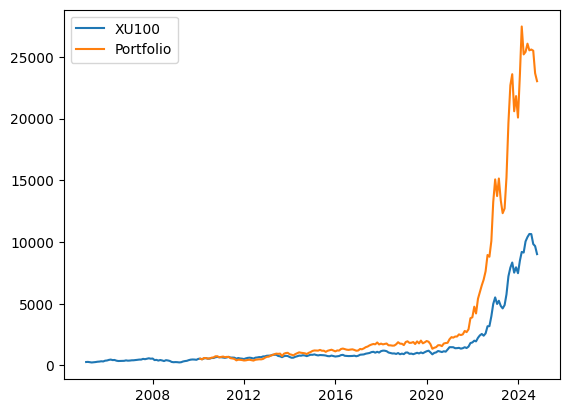

In [6]:
import json

# Creating a portfolio dataframe to see the results of the investment.
portfolio = pd.DataFrame()
portfolio['Date'] = DF.index
portfolio = portfolio.set_index('Date')
portfolio['Money'] = np.nan
portfolio['Weight'] = np.nan
portfolio['BJKAS.IS'] = np.nan
portfolio['ENKAI.IS'] = np.nan
portfolio['THYAO.IS'] = np.nan
portfolio['TUPRS.IS'] = np.nan
portfolio['YKBNK.IS'] = np.nan
portfolio['ARCLK.IS'] = np.nan
portfolio['MGROS.IS'] = np.nan
portfolio['ULKER.IS'] = np.nan
portfolio['ALARK.IS'] = np.nan
portfolio['ZOREN.IS'] = np.nan

# Our initial money is the value of XU100 at the beginning of the investment date.
# We will optimize the weights of the portfolio using the last 60 months of data.
money = XU100.iloc[59].values[0]

# We will optimize weights by using past 60 month, and iterate this for every month.
for i in range(0, len(DF)-60, 1):

    # 60 month data
    PAST_RETURNS = PCT[i:60+i]

    # Covariance Matrix
    COV_MATRIX = PAST_RETURNS.cov()

    # Number of assets, 10 in this example
    NUM_ASSETS = 10

    # Initial random weights
    x0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

    # Portfolio Coefficient of Variation Function
    # We will minimize this function to find the optimal weights
    def portfolio_cv(weights, PAST_RETURNS, COV_MATRIX):
        std = np.sqrt(np.dot(weights.T, np.dot(COV_MATRIX, weights)))
        mean = np.dot(weights, PAST_RETURNS.mean()) # Should be mean() or prod() ?
        return std / mean
    
    # Optimize weights for every 3 months
    if i % 3 == 0:
        # Optimizing the weights
        optimized_weights = minimize(
            fun = portfolio_cv,
            x0 = x0,
            args = (PAST_RETURNS, COV_MATRIX),
            method = 'SLSQP',
            bounds = [(0, 1)] * NUM_ASSETS, # Weights must be between 0 and 1
            constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Sum of weights must be 1
            )

    # Change value of money with the result of investment
    # We invested, earned or lost money
    money = money * optimized_weights.x @ (1 + PCT.iloc[60+i])

    portfolio.iloc[i+60, portfolio.columns.get_loc('Money')] = money
    for asset, weight in zip(['BJKAS.IS', 'ENKAI.IS', 'THYAO.IS', 'TUPRS.IS', 'YKBNK.IS', 'ARCLK.IS', 'MGROS.IS', 'ULKER.IS', 'ALARK.IS', 'ZOREN.IS'], optimized_weights.x):
        portfolio.iloc[i+60, portfolio.columns.get_loc(asset)] = weight

print(portfolio.iloc[-1])
plt.plot(XU100, label='XU100')
plt.plot(portfolio['Money'], label='Portfolio')
plt.legend()


In [7]:
portfolio.head(65)

,Money,Weight,BJKAS.IS,ENKAI.IS,THYAO.IS,TUPRS.IS,YKBNK.IS,ARCLK.IS,MGROS.IS,ULKER.IS,ALARK.IS,ZOREN.IS
Date,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-31,537.470521,NaN,0.050783,0.163248,0.238304,0.289227,9.344806e-16,0.0,0.258439,0.0,4.497711e-18,0.0
2010-02-28,487.126279,NaN,0.050783,0.163248,0.238304,0.289227,9.344806e-16,0.0,0.258439,0.0,4.497711e-18,0.0
2010-03-31,598.079394,NaN,0.050783,0.163248,0.238304,0.289227,9.344806e-16,0.0,0.258439,0.0,4.497711e-18,0.0


In [8]:
portfolio.Money.to_clipboard()